# Perturbation Tracers 2

We measure tracers of the (tidal) perturbations on each OC, spatial and dynamical.


- Testing perturbation map with struct imag

In [1]:
using PyCall
using Statistics , MultivariateStats
using Printf
using ImageFiltering
using Query, DataFrames

import PyPlot , CSV , Distances

sns= pyimport("seaborn")

rootdir = ENV["GAIA_ROOT"]
push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

#Constants
const G= 4.30091e-3   #[solar mass][pc][km/s]

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/plots"
ocdir= "$wdir/oc2"

cd(wdir)

In [2]:
## testing struct imag
mutable struct imag
    nx::Int
    ny::Int
    xrange::Array{Float64}
    yrange::Array{Float64}
    dat::Array{Float64,2}
end

1×7 DataFrame
│ Row │ votname             │ C       │ Cerr     │ s       │ serr     │ m       │ merr      │
│     │ String              │ Float64 │ Float64  │ Float64 │ Float64  │ Float64 │ Float64   │
├─────┼─────────────────────┼─────────┼──────────┼─────────┼──────────┼─────────┼───────────┤
│ 1   │ NGC 2168-4.9deg.vot │ 

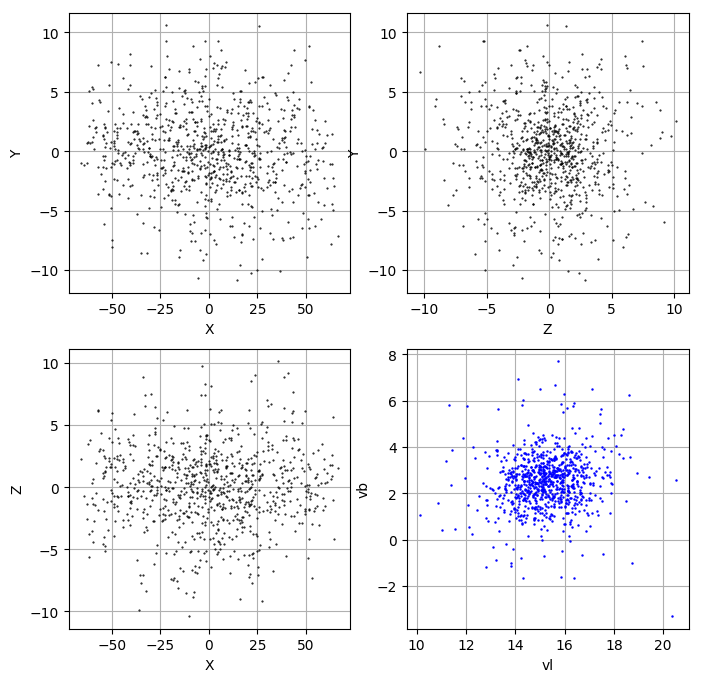

17.6176 │ 0.157554 │ 6.16502 │ 0.090917 │ 3.49674 │ 0.0570396 │


In [3]:
## Reading the test OC

#ocname= "NGC 6025-1.7deg-oc-mass.csv"
#ocname= "NGC 2516-3.5deg-oc-mass.csv"
#ocname= "NGC 2632-15.5deg-oc-mass.csv"
#ocname= "NGC 2670-1.0deg-oc-mass.csv"
#ocname= "NGC 3114-1.7deg-oc-mass.csv"
#ocname= "ASCC 97-1.7deg-oc-mass.csv"
ocname= "NGC 2168-4.9deg-oc-mass.csv"

oc= CSV.read("$ocdir/$ocname", delim= ";")
cfit= CSV.read("fitCauchy-p100-20k.csv", delim= ";")
votname= ocname[1:end-12]*".vot"

dfit = @from i in cfit begin
    @where i.votname == votname
    @select i
    @collect DataFrame
end
println(dfit)

## OC recentered
oc.X= oc.X .- mean(oc.X)
oc.Y= oc.Y .- mean(oc.Y)
oc.Z= oc.Z .- mean(oc.Z)

fig= PyPlot.figure(figsize=(8,8))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(oc.X, oc.Y,"k.",markersize=1)
PyPlot.xlabel("X") ; PyPlot.ylabel("Y")
ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.plot(oc.Z, oc.Y,"k.", markersize=1)
PyPlot.xlabel("Z") ; PyPlot.ylabel("Y")
ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.plot(oc.X, oc.Z,"k.",markersize=1)
PyPlot.xlabel("X") ; PyPlot.ylabel("Z")
ax= PyPlot.subplot(224)
PyPlot.grid("on")
PyPlot.plot(oc.vl, oc.vb,"b.",markersize= 1.5 )
PyPlot.xlabel("vl") ; PyPlot.ylabel("vb")
PyPlot.show()

## Perturbation map

Perturbation map of the 2D density using the Cauchy fit

**Important Note**: look at the coordinate for the image which are quite tricky because of the 0-index and 1-index in python and matplotlib <br>
**Important Note**: Virial mass is overestimated... <br>

In [4]:
# Cauchy fit
#
# Best solution

θ= modelCauchy(dfit.C[1],dfit.s[1],dfit.m[1])


modelCauchy(17.617628010096915, 6.165023793017823, 3.4967371834997985)

In [5]:
## density 2d
## we assume the map is SQUARE
function _xy2pix(x, xmin, dl)::Int
    ix1= (x-xmin)/dl + 1
    ixy= convert(Int,floor(ix1+0.5))
    
    return(ixy)
end

function _pix2xy(i, xmin, dl)
    x= xmin + (i-1)*dl
    return(x)
end

function _dens2d(x,y, xyrange=[-1,1], nbin=10)
    dens= zeros(Float64,nbin,nbin)
    dl= (xyrange[2]-xyrange[1]) / (nbin-1)
    
    for i in 1:length(x)
        ix= _xy2pix(x[i],xyrange[1],dl)
        iy= _xy2pix(y[i],xyrange[1],dl)
        
        if ix>0 && ix<=nbin && iy>0 && iy<=nbin
            dens[ix,iy]+=1.0
        end
    end
    
    dS= dl*dl
    dens= dens ./ dS
    
    densim= imag(nbin,nbin,xyrange,xyrange,dens)
    
    return(densim)
end

function _dens_pert(dens2d::imag, θ::modelCauchy, fdens::Function)
    nbin=dens2d.nx
    if dens2d.nx != dens2d.ny
        println("## Warning, not a square density image")
    end
    dl= (dens2d.xrange[2]-dens2d.xrange[1]) / (nbin-1)
    pert2d= copy(dens2d.dat)
    
    for i in 1:nbin
        for j in 1:nbin
            xx=  _pix2xy(i, dens2d.xrange[1],dl)
            yy=  _pix2xy(j, dens2d.xrange[1],dl)
            
            rr= sqrt(xx*xx+yy*yy)
            dmodel= fdens(rr, θ)
            pert2d[i,j]-=dmodel
            
        end
    end
    
    pert2dim=copy(dens2d)
    pert2dim.dat= pert2d
    return(pert2dim)
end

_dens_pert (generic function with 1 method)

In [6]:
lrange=[-10,10]
nbin=51
densim= _dens2d(oc.Y,oc.Z,lrange,nbin)
pertim= _dens_pert(densim,θ, fdens1)


## smoothing
σsmooth= 1.0
densg= imfilter(densim.dat, reflect(Kernel.gaussian(σsmooth))) 
pertg= imfilter(pertim.dat, reflect(Kernel.gaussian(σsmooth)))


fig= PyPlot.figure(figsize=(10,10))
ax1= PyPlot.subplot(211)
ax1.set_xlim(lrange[1],lrange[2])
ax1.set_ylim(lrange[1],lrange[2])
PyPlot.grid("on")
pos= PyPlot.imshow(densg, cmap="CMRmap_r", interpolation= "nearest", 
    extent=[lrange[1], lrange[2], lrange[2], lrange[1]])
fig.colorbar(pos, ax=ax1)


vmin= - max(maximum(pertg), abs(minimum(pertg)))
vmax= -vmin
ax2= PyPlot.subplot(212)
ax2.set_xlim(lrange[1],lrange[2])
ax2.set_ylim(lrange[1],lrange[2])
PyPlot.grid("on")
pos= PyPlot.imshow(pertg, cmap="seismic", vmin=vmin,vmax=vmax ,interpolation= "nearest",
    extent=[lrange[1], lrange[2], lrange[2], lrange[1]])
fig.colorbar(pos, ax=ax2)


PyPlot.show()

MethodError: MethodError: no method matching copy(::imag)
Closest candidates are:
  copy(!Matched::Expr) at expr.jl:36
  copy(!Matched::Core.CodeInfo) at expr.jl:64
  copy(!Matched::BitSet) at bitset.jl:46
  ...